In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [14]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:22<00:00,  5.54it/s]


In [15]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [741]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [742]:
answers = []
code2answers= defaultdict(list)
for code , convos in code2convos.items():
    gpt_ans = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            gpt_ans.append(conv["text"])
    code2answers[code] = gpt_ans

In [743]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [744]:
q_scores = {
    'q0': 0,
    'q1': 5,
    'q2': 15,
    'q3': 5,
    'q4': 10,
    'q5': 20,
    'q6': 15,
    'q7': 20,
    'q8': 10,
}

In [745]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [746]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [679]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [747]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [748]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [752]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [750]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [753]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


In [754]:
# Function to sum scores
def sum_scores(row):
    total_score = 0
    for question, score in q_scores.items():
        column_name = 'Q_' + question[1:]  # Corresponding column name in df
        if column_name in question_mapping_scores.columns:
            total_score += score* row[column_name]
    return total_score

# Apply the function to each row
question_mapping_scores['Total_Score'] = question_mapping_scores.apply(sum_scores, axis=1)

print(question_mapping_scores)


                                     code       Q_0       Q_1       Q_2  \
0    0031c86e-81f4-4eef-9e0e-28037abf9883  0.153541  0.294879  0.522169   
1    0225686d-b825-4cac-8691-3a3a5343df2b  0.192013  0.795607  0.772184   
2    041f950b-c013-409a-a642-cffff60b9d4b  0.258306  0.295923  0.624824   
3    04f91058-d0f8-4324-83b2-19c671f433dc  0.145965  0.117841  0.267346   
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34  0.344182  0.575528  0.782883   
..                                    ...       ...       ...       ...   
118  f24219d6-07f0-4baf-80ac-18475dc5b66f  0.187393  0.209889  0.358875   
119  f2f18684-4a16-4c05-a2d1-c0f96d1de869  0.144760  0.139495  0.332267   
120  f852596d-fdca-45aa-9050-d4f76ce6a53c  0.211008  0.908697  0.977725   
121  f8ec3336-fd48-4654-ad98-62ccfb96d096  0.173215  0.967321  1.000000   
122  fb8de815-224c-4d06-9fd4-7156d1a9920d  0.170293  0.712409  0.835236   

          Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  Total_Score  
0    0.352243  0.460

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [783]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["thank", "next", "Entropy", "=", "hyperparameters", "error", "why", "correlation", "how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [784]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,#error,#why,#correlation,#how,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,4.0,12.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.0,2.0,0.0,4.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,3.0,1.0,0.0,2.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,9.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,1.0,3.0,11.0,20.0,0.017986,18.850913


In [785]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


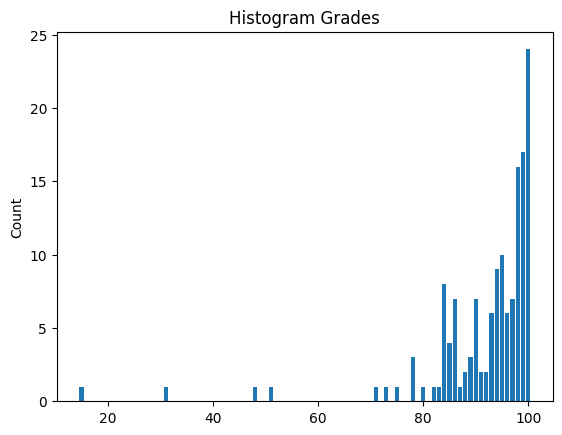

In [786]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [787]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,#error,#why,#correlation,#how,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,4.0,12.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.0,2.0,0.0,4.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,3.0,1.0,0.0,2.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,9.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,1.0,3.0,11.0,20.0,0.017986,18.850913


In [788]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,#error,#why,#correlation,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Total_Score
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,4.0,...,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,34.873644
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.0,2.0,0.0,...,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,76.037702
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,3.0,1.0,0.0,...,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,50.420088
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,...,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,27.899428
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,1.0,3.0,11.0,...,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,76.732951


In [789]:
df['Average'] = df[['Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8']].mean(axis=1)
df['std'] = df[['Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8']].std(axis=1)

#### Clustering

In [790]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df.drop(['code'], axis =1))  # Assuming df is your DataFrame


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

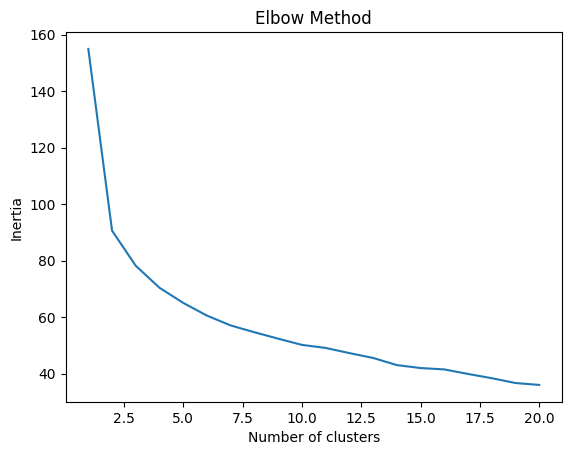

In [791]:
inertia = []
for i in range(1, 21):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 21), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [792]:
k=6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [793]:
df['Cluster'] = clusters

In [794]:
df['Cluster'].value_counts()

2    32
0    24
4    18
3    17
1    16
5    16
Name: Cluster, dtype: int64

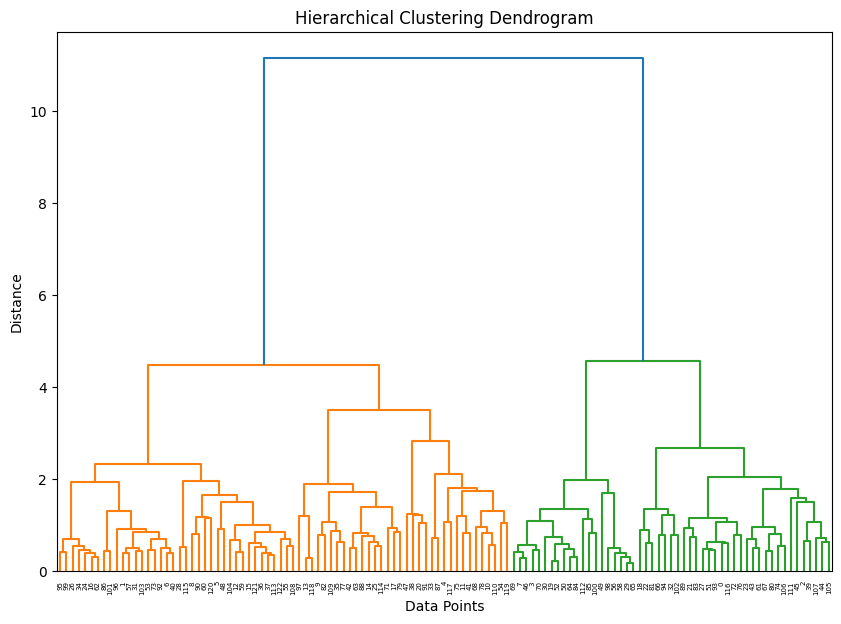

In [795]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Performing hierarchical clustering
Z = linkage(scaled_df, method='ward')

# Plotting dendrogram
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, labels=df.index)
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


In [ ]:
clusters = fcluster(Z, t=4, criterion='distance')

# Adding cluster labels to the DataFrame
df['Cluster'] = clusters

In [ ]:
df['Cluster'].value_counts()

1    30
7    21
5    21
4    17
2    15
6    10
3     9
Name: Cluster, dtype: int64

#### Merging scores with features

In [796]:
temp_df = pd.merge(df, scores, on='code', how="right")

In [774]:
temp_df.drop_duplicates("code",inplace=True, keep="first")

In [797]:
"""
139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
"""

import pandas as pd
import numpy as np

# Parameters
k = 5  # number of nearest neighbors
# List of codes and columns with empty values
codes_to_fill = ["139235c7-736c-4237-92f0-92e8c116832c", "668ad17e-0240-49f7-b5a7-d22e502554c6",
                 "b0640e51-6879-40cb-a4f5-329f952ef99d", "da6b70d5-29f6-491a-ad46-037c77067128"]
columns_to_fill = temp_df.columns

for code in codes_to_fill:
    for column in columns_to_fill:
        row = temp_df[(temp_df['code'] == code) & (temp_df[column].isna())]

        if not row.empty:
            # Get the grade of the student with the missing value
            grade = row['grade'].iloc[0]

            # Calculate the absolute difference in grades
            temp_df['grade_diff'] = temp_df['grade'].apply(lambda x: abs(x - grade))

            # Exclude the current code and sort by grade difference
            closest_students = temp_df[(temp_df['code'] != code)].sort_values(by='grade_diff').head(k)

            # Compute the average value of these students for the specific column
            average_value = closest_students[column].mean()

            # Fill the missing value with the average
            temp_df.loc[(temp_df['code'] == code) & (temp_df[column].isna()), column] = average_value

            # Drop the temporary 'grade_diff' column
            temp_df.drop(columns=['grade_diff'], inplace=True)

# temp_df now has the missing values filled

In [798]:
temp_df.isnull().sum()

code                  0
#user_prompts         0
#thank                0
#next                 0
#entropy              0
#=                    0
#hyperparameters      0
#error                0
#why                  0
#correlation          0
#how                  0
prompt_avg_chars      0
response_avg_chars    0
Q_0                   0
Q_1                   0
Q_2                   0
Q_3                   0
Q_4                   0
Q_5                   0
Q_6                   0
Q_7                   0
Q_8                   0
Total_Score           0
Average               0
std                   0
Cluster               0
grade                 1
dtype: int64

In [799]:
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,#error,#why,#correlation,...,Q_4,Q_5,Q_6,Q_7,Q_8,Total_Score,Average,std,Cluster,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.022614,0.059760,0.044272,0.030223,0.060247,4.122640,0.038039,0.026245,3.0,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,...,0.333889,0.309084,0.192434,0.261892,0.407106,27.899428,0.261374,0.093911,0.0,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,20.0,0.0,0.0,3.0,0.0,9.0,0.0,1.0,0.0,...,0.607114,0.834963,0.749319,0.457643,0.530808,64.142892,0.600445,0.203886,4.0,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,17.0,0.0,0.0,2.0,1.0,8.0,2.0,2.0,0.0,...,0.724872,0.889976,0.947377,0.827463,0.562910,80.912376,0.714626,0.240134,2.0,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,66.0,0.0,0.0,9.0,11.0,30.0,1.0,5.0,8.0,...,0.942662,0.606780,1.000000,1.000000,0.717228,86.707656,0.811366,0.279182,2.0,93.0


#### Correlation Exploration

<ipython-input-800-1bf414c563f7>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = temp_df.corr()


Correlations with the target variable ('grade'):
grade                 1.000000
#user_prompts         0.187878
std                   0.182246
#correlation          0.149340
Q_5                   0.148483
Q_7                   0.147935
Q_8                   0.147021
#thank                0.139237
Total_Score           0.135723
Q_6                   0.135068
Q_3                   0.134869
#why                  0.132023
#entropy              0.129674
#=                    0.119302
Average               0.109590
#hyperparameters      0.099867
#next                 0.075335
Cluster               0.072168
Q_2                   0.070337
Q_1                   0.031505
#error                0.028972
Q_4                   0.002164
#how                 -0.021990
Q_0                  -0.204723
response_avg_chars   -0.417887
prompt_avg_chars     -0.442409
Name: grade, dtype: float64


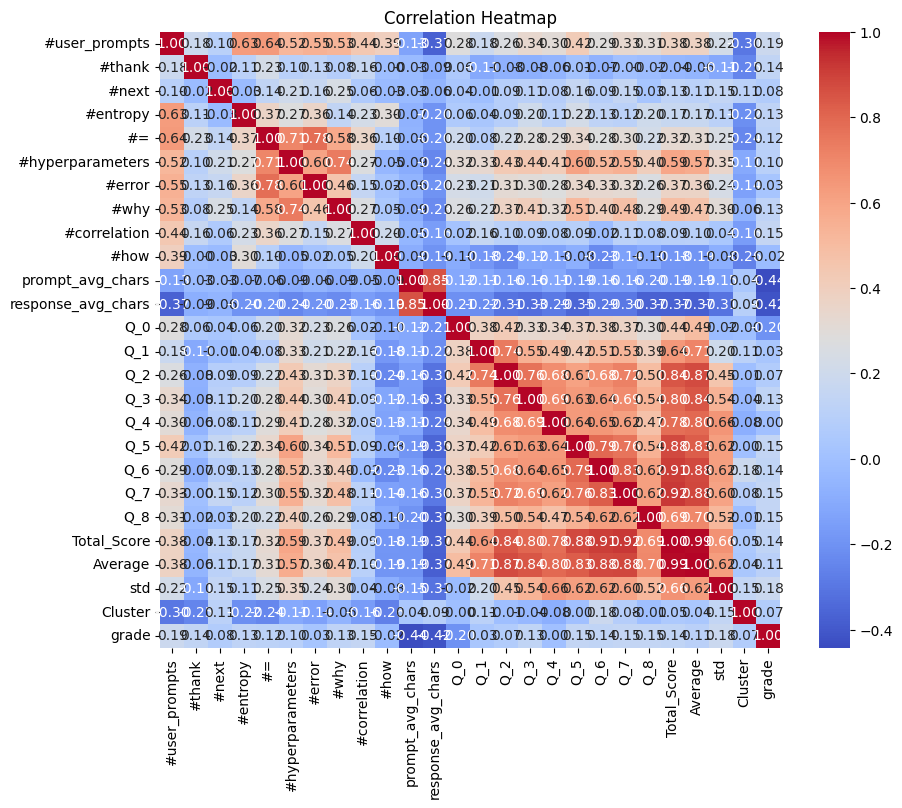


Best 3 features based on absolute values of correlations:
Index(['prompt_avg_chars', 'response_avg_chars', 'Q_0'], dtype='object')


In [800]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations for all features
correlations = temp_df.corr()

# Highlight strong correlations with the target variable ('health_metrics')
target_correlations = correlations['grade'].sort_values(ascending=False)
print("Correlations with the target variable ('grade'):")
print(target_correlations)

# Plot the results in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Select the best 3 features based on absolute values of correlations
best_features = target_correlations.drop('grade').abs().nlargest(3).index

print("\nBest 3 features based on absolute values of correlations:")
print(best_features)

In [695]:
temp_df.drop(['Q_4'], axis = 1, inplace = True)

#### Train/Test split

In [1185]:
c1 = temp_df[temp_df['Cluster'] == 0]
c2 = temp_df[temp_df['Cluster'] == 1]
c3 = temp_df[temp_df['Cluster'] == 2]
c4 = temp_df[temp_df['Cluster'] == 3]
c5 = temp_df[temp_df['Cluster'] == 4]
c6 = temp_df[temp_df['Cluster'] == 5]
c7 = temp_df[temp_df['Cluster'] == 6]


In [1186]:
X1 = c1[c1.columns[1:-1]].to_numpy()
y1 = c1["grade"].to_numpy()
print(X1.shape, y1.shape)

X2 = c2[c2.columns[1:-1]].to_numpy()
y2 = c2["grade"].to_numpy()
print(X2.shape, y2.shape)

X3 = c3[c3.columns[1:-1]].to_numpy()
y3 = c3["grade"].to_numpy()
print(X3.shape, y3.shape)

X4 = c4[c4.columns[1:-1]].to_numpy()
y4 = c4["grade"].to_numpy()
print(X4.shape, y4.shape)

X5 = c5[c5.columns[1:-1]].to_numpy()
y5 = c5["grade"].to_numpy()
print(X5.shape, y5.shape)

X6 = c6[c6.columns[1:-1]].to_numpy()
y6 = c6["grade"].to_numpy()
print(X6.shape, y6.shape)


(23, 25) (23,)
(16, 25) (16,)
(32, 25) (32,)
(17, 25) (17,)
(18, 25) (18,)
(16, 25) (16,)


In [1187]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
print("Train set size:", len(X_train1))
print("Test set size:", len(X_test1))

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
print("Train set size:", len(X_train2))
print("Test set size:", len(X_test2))

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
print("Train set size:", len(X_train3))
print("Test set size:", len(X_test3))

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)
print("Train set size:", len(X_train4))
print("Test set size:", len(X_test4))

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)
print("Train set size for dataset 5:", len(X_train5))
print("Test set size for dataset 5:", len(X_test5))

# Splitting dataset 6
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2, random_state=42)
print("Train set size for dataset 6:", len(X_train6))
print("Test set size for dataset 6:", len(X_test6))


Train set size: 18
Test set size: 5
Train set size: 12
Test set size: 4
Train set size: 25
Test set size: 7
Train set size: 13
Test set size: 4
Train set size for dataset 5: 14
Test set size for dataset 5: 4
Train set size for dataset 6: 12
Test set size for dataset 6: 4


In [1206]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(126, 25) (126,)


In [1207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 100
Test set size: 26


#### Predicting and Analyzing

##### Cluster 1

In [1191]:
from sklearn.ensemble import RandomForestRegressor
regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error')
regressor.fit(X_train1, y_train1)
regressor_rf = RandomForestRegressor(random_state=42,criterion='squared_error', n_estimators = 200)
regressor_rf.fit(X_train1, y_train1)

# Prediction
y_train_pred = regressor.predict(X_train1)
y_test_pred = regressor.predict(X_test1)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train1,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test1,y_test_pred))

print("R2 Train:", r2_score(y_train1,y_train_pred))
print("R2 TEST:", r2_score(y_test1,y_test_pred))

# Prediction
y_train_pred_rf = regressor_rf.predict(X_train1)
y_test_pred_rf = regressor_rf.predict(X_test1)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train1,y_train_pred_rf))
print("MSE TEST:", mean_squared_error(y_test1,y_test_pred_rf))

print("R2 Train:", r2_score(y_train1,y_train_pred_rf))
print("R2 TEST:", r2_score(y_test1,y_test_pred_rf))

MSE Train: 0.0
MSE TEST: 93.0
R2 Train: 1.0
R2 TEST: -2.035248041775457
MSE Train: 32.12974583333332
MSE TEST: 96.28911499999997
R2 Train: 0.8602529446115019
R2 TEST: -2.1425951370757175


##### Cluster 2

In [1193]:
regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error', max_depth=10)
regressor.fit(X_train2, y_train2)
regressor_rf = RandomForestRegressor(random_state=42,criterion='squared_error', n_estimators = 100, max_depth=4)
regressor_rf.fit(X_train2, y_train2)

# Prediction
y_train_pred = regressor.predict(X_train2)
y_test_pred = regressor.predict(X_test2)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train2,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test2,y_test_pred))

print("R2 Train:", r2_score(y_train2,y_train_pred))
print("R2 TEST:", r2_score(y_test2,y_test_pred))

# Prediction
y_train_pred_rf = regressor_rf.predict(X_train2)
y_test_pred_rf = regressor_rf.predict(X_test2)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train2,y_train_pred_rf))
print("MSE TEST:", mean_squared_error(y_test2,y_test_pred_rf))

print("R2 Train:", r2_score(y_train2,y_train_pred_rf))
print("R2 TEST:", r2_score(y_test2,y_test_pred_rf))

MSE Train: 0.0
MSE TEST: 196.25
R2 Train: 1.0
R2 TEST: -5.7237687366167025
MSE Train: 6.075614004629631
MSE TEST: 92.34392777777782
R2 Train: 0.8748729381197559
R2 TEST: -2.163817654056628


##### Cluster 3

In [1194]:
regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error', max_depth=3)
regressor.fit(X_train3, y_train3)
regressor_rf = RandomForestRegressor(random_state=42,criterion='squared_error', n_estimators = 100, max_depth=3)
regressor_rf.fit(X_train3, y_train3)

# Prediction
y_train_pred = regressor.predict(X_train3)
y_test_pred = regressor.predict(X_test3)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train3,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test3,y_test_pred))

print("R2 Train:", r2_score(y_train3,y_train_pred))
print("R2 TEST:", r2_score(y_test3,y_test_pred))

# Prediction
y_train_pred_rf = regressor_rf.predict(X_train3)
y_test_pred_rf = regressor_rf.predict(X_test3)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train3,y_train_pred_rf))
print("MSE TEST:", mean_squared_error(y_test3,y_test_pred_rf))

print("R2 Train:", r2_score(y_train3,y_train_pred_rf))
print("R2 TEST:", r2_score(y_test3,y_test_pred_rf))

MSE Train: 9.390877192982456
MSE TEST: 50.42716440223365
R2 Train: 0.9643017124720885
R2 TEST: -1.1301129790598696
MSE Train: 51.82591650439049
MSE TEST: 55.324955052603514
R2 Train: 0.8029900263040614
R2 TEST: -1.3370024117048036


##### Cluster 4

In [1195]:
regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error', max_depth=10)
regressor.fit(X_train4, y_train4)
regressor_rf = RandomForestRegressor(random_state=42,criterion='squared_error', n_estimators = 250, max_depth=10)
regressor_rf.fit(X_train4, y_train4)

# Prediction
y_train_pred = regressor.predict(X_train4)
y_test_pred = regressor.predict(X_test4)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train4,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test4,y_test_pred))

print("R2 Train:", r2_score(y_train4,y_train_pred))
print("R2 TEST:", r2_score(y_test4,y_test_pred))

# Prediction
y_train_pred_rf = regressor_rf.predict(X_train4)
y_test_pred_rf = regressor_rf.predict(X_test4)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train4,y_train_pred_rf))
print("MSE TEST:", mean_squared_error(y_test4,y_test_pred_rf))

print("R2 Train:", r2_score(y_train4,y_train_pred_rf))
print("R2 TEST:", r2_score(y_test4,y_test_pred_rf))

MSE Train: 0.0
MSE TEST: 255.25
R2 Train: 1.0
R2 TEST: -13.034364261168385
MSE Train: 39.03248492307694
MSE TEST: 792.4970159999999
R2 Train: 0.8685329649234693
R2 TEST: -42.5737190927835


##### Cluster 5

In [1196]:
regressor5 = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth=10)
regressor5.fit(X_train5, y_train5)
regressor_rf5 = RandomForestRegressor(random_state=42, criterion='squared_error', n_estimators=250, max_depth=10)
regressor_rf5.fit(X_train5, y_train5)

# Prediction and Evaluation for dataset 5
y_train_pred5 = regressor5.predict(X_train5)
y_test_pred5 = regressor5.predict(X_test5)
print("Dataset 5 - Decision Tree Regressor")
print("MSE Train:", mean_squared_error(y_train5, y_train_pred5))
print("MSE Test:", mean_squared_error(y_test5, y_test_pred5))
print("R2 Train:", r2_score(y_train5, y_train_pred5))
print("R2 Test:", r2_score(y_test5, y_test_pred5))

y_train_pred_rf5 = regressor_rf5.predict(X_train5)
y_test_pred_rf5 = regressor_rf5.predict(X_test5)
print("Dataset 5 - Random Forest Regressor")
print("MSE Train:", mean_squared_error(y_train5, y_train_pred_rf5))
print("MSE Test:", mean_squared_error(y_test5, y_test_pred_rf5))
print("R2 Train:", r2_score(y_train5, y_train_pred_rf5))
print("R2 Test:", r2_score(y_test5, y_test_pred_rf5))

Dataset 5 - Decision Tree Regressor
MSE Train: 0.0
MSE Test: 34.5
R2 Train: 1.0
R2 Test: -5.9
Dataset 5 - Random Forest Regressor
MSE Train: 7.861415999999993
MSE Test: 7.495711999999991
R2 Train: 0.8489967134457077
R2 Test: -0.4991423999999982


##### Cluster 6-7

In [1197]:
# For dataset 6
regressor6 = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth=10)
regressor6.fit(X_train6, y_train6)
regressor_rf6 = RandomForestRegressor(random_state=42, criterion='squared_error', n_estimators=250, max_depth=10)
regressor_rf6.fit(X_train6, y_train6)

# Prediction and Evaluation for dataset 6
y_train_pred6 = regressor6.predict(X_train6)
y_test_pred6 = regressor6.predict(X_test6)
print("\nDataset 6 - Decision Tree Regressor")
print("MSE Train:", mean_squared_error(y_train6, y_train_pred6))
print("MSE Test:", mean_squared_error(y_test6, y_test_pred6))
print("R2 Train:", r2_score(y_train6, y_train_pred6))
print("R2 Test:", r2_score(y_test6, y_test_pred6))

y_train_pred_rf6 = regressor_rf6.predict(X_train6)
y_test_pred_rf6 = regressor_rf6.predict(X_test6)
print("Dataset 6 - Random Forest Regressor")
print("MSE Train:", mean_squared_error(y_train6, y_train_pred_rf6))
print("MSE Test:", mean_squared_error(y_test6, y_test_pred_rf6))
print("R2 Train:", r2_score(y_train6, y_train_pred_rf6))
print("R2 Test:", r2_score(y_test6, y_test_pred_rf6))

# For dataset 7
regressor7 = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth=10)
regressor7.fit(X_train7, y_train7)
regressor_rf7 = RandomForestRegressor(random_state=42, criterion='squared_error', n_estimators=250, max_depth=10)
regressor_rf7.fit(X_train7, y_train7)

# Prediction and Evaluation for dataset 7
y_train_pred7 = regressor7.predict(X_train7)
y_test_pred7 = regressor7.predict(X_test7)
print("\nDataset 7 - Decision Tree Regressor")
print("MSE Train:", mean_squared_error(y_train7, y_train_pred7))
print("MSE Test:", mean_squared_error(y_test7, y_test_pred7))
print("R2 Train:", r2_score(y_train7, y_train_pred7))
print("R2 Test:", r2_score(y_test7, y_test_pred7))

y_train_pred_rf7 = regressor_rf7.predict(X_train7)
y_test_pred_rf7 = regressor_rf7.predict(X_test7)
print("Dataset 7 - Random Forest Regressor")
print("MSE Train:", mean_squared_error(y_train7, y_train_pred_rf7))
print("MSE Test:", mean_squared_error(y_test7, y_test_pred_rf7))
print("R2 Train:", r2_score(y_train7, y_train_pred_rf7))
print("R2 Test:", r2_score(y_test7, y_test_pred_rf7))



Dataset 6 - Decision Tree Regressor
MSE Train: 0.0
MSE Test: 125.75
R2 Train: 1.0
R2 Test: -2.698529411764706
Dataset 6 - Random Forest Regressor
MSE Train: 7.031689333333346
MSE Test: 70.70896800000001
R2 Train: 0.8252694971527176
R2 Test: -1.079675529411765

Dataset 7 - Decision Tree Regressor
MSE Train: 0.0
MSE Test: 256.0
R2 Train: 1.0
R2 Test: nan
Dataset 7 - Random Forest Regressor
MSE Train: 15.256981333333357
MSE Test: 55.17518399999996
R2 Train: 0.827928781954887
R2 Test: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


##### All

In [1223]:
from sklearn.ensemble import RandomForestRegressor
regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error')
regressor.fit(X_train, y_train)

regressor_rf = RandomForestRegressor(criterion='squared_error', n_estimators=200)
regressor_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [830]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 93.55710000000181
Node 1 has MSE 0.0
Node 2 has MSE 54.93929190898962
Node 3 has MSE 152.86222222222295
Node 4 has MSE 31.222222222222626
Node 5 has MSE 25.555555555556566
Node 6 has MSE 7.888888888889596
Node 7 has MSE 0.6875
Node 8 has MSE 0.0
Node 9 has MSE 0.25
Node 10 has MSE 0.25
Node 11 has MSE 0.0
Node 12 has MSE 0.0
Node 13 has MSE 6.888888888890506
Node 14 has MSE 0.25
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 0.22222222222262644
Node 19 has MSE 0.0
Node 20 has MSE 0.0
Node 21 has MSE 308.66666666666697
Node 22 has MSE 100.0
Node 23 has MSE 0.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 30.776643990931916
Node 27 has MSE 24.427501826150547
Node 28 has MSE 0.0
Node 29 has MSE 20.45674610621063
Node 30 has MSE 17.506745562130163
Node 31 has MSE 22.429752066116635
Node 32 has MSE 16.56000000000131
Node 33 has MSE 6.91666666666606
Node 34 has MSE 11.967550027042307
Node 35 has MSE 3.5068359375
Node 36 has MSE 30.776859

In [1217]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [1224]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.0
MSE TEST: 374.6923076923077
R2 Train: 1.0
R2 TEST: -0.15264233284338036


In [ ]:
# Prediction
y_train_pred_rf = regressor_rf.predict(X_train)
y_test_pred_rf = regressor_rf.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred_rf))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred_rf))

print("R2 Train:", r2_score(y_train,y_train_pred_rf))
print("R2 TEST:", r2_score(y_test,y_test_pred_rf))

MSE Train: 39.020655628865974
MSE TEST: 97.60391808
R2 Train: 0.7612252238768696
R2 TEST: 0.1305981700538722


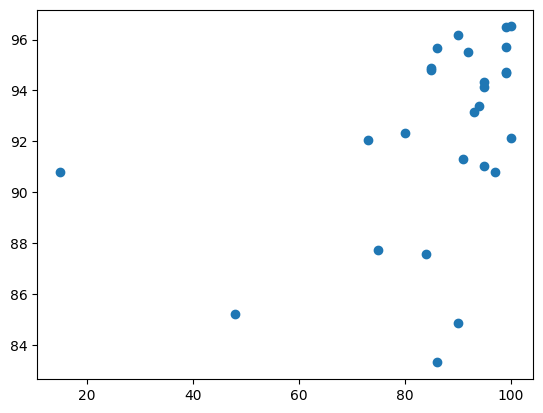

In [834]:
plt.scatter(y_test, y_test_pred_rf)

# Regression From Text

In [1069]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = ""
    for conv in convos:
        if conv["role"] == "user":
            user_prompts = user_prompts + " " + conv["text"].lower()
    prompts.append(user_prompts)
    code2prompts[code] = user_prompts

In [1070]:
answers = []
code2answers= defaultdict(list)
for code , convos in code2convos.items():
    gpt_ans = ""
    for conv in convos:
        if conv["role"] == "assistant":
            gpt_ans = gpt_ans + " " + conv["text"].lower()
    answers.append([gpt_ans])
    code2answers[code] = gpt_ans

In [1071]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


In [1072]:
code_prompts = pd.DataFrame(code2prompts, index=[0]).T
code_prompts.reset_index(inplace=True)
code_prompts.rename(columns={0: "prompts"}, inplace=True)
code_prompts.rename(columns={"index" : "code"}, inplace=True)

In [1073]:
code_ans = pd.DataFrame(code2answers, index=[0]).T
code_ans.reset_index(inplace=True)
code_ans.rename(columns={0: "answers"}, inplace=True)
code_ans.rename(columns={"index" : "code"}, inplace=True)

In [1074]:
df_prompt = pd.merge(code_prompts, scores, on="code", how="left")
df_prompt.head()

,code,prompts,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,load a csv file into a pandas in python. the ...,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,i have a dataset that contains the following ...,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,i have a csv file data with columns:\n\nspeci...,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,how can i display variable names in a pandas ...,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,i am doing a machine leraning homework using ...,100.0


In [1075]:
df_prompt.dropna(inplace=True)
df_prompt.drop_duplicates("code",inplace=True, keep="first")

In [1076]:
df_ans = pd.merge(code_ans, scores, on="code", how="left")
df_ans.head()

,code,answers,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,you can load a csv file into a pandas datafra...,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,great! it looks like you have a comprehensive...,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,certainly! let's go through each step.step 1:...,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,"in pandas, you can display variable (column) ...",97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,absolutely! here's the code to import the nec...,100.0


In [1077]:
df_ans.dropna(inplace=True)
df_ans.drop_duplicates("code",inplace=True, keep="first")

In [1078]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_prompt['prompts'], df_prompt['grade'], test_size=0.2, random_state=42)
print("Train set size:", len(X_train_p))
print("Test set size:", len(X_test_p))

Train set size: 100
Test set size: 26


In [1079]:
X_train, X_test, y_train, y_test = train_test_split(df_ans['answers'], df_ans['grade'], test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 100
Test set size: 26


## BoW

In [1097]:
#ANSWERS
from sklearn.feature_extraction.text import CountVectorizer

max_features = 500
vectorizer = CountVectorizer(max_features=max_features, preprocessor=lambda x: x)

# Fit the vectorizer to your train data
vectorizer.fit(X_train)

# Transform the train and test data
train_bow = vectorizer.transform(X_train).toarray()
test_bow = vectorizer.transform(X_test).toarray()

In [1098]:
#PROMPTS
from sklearn.feature_extraction.text import CountVectorizer

max_features = 500
vectorizer_p = CountVectorizer(max_features=max_features, preprocessor=lambda x: x)

# Fit the vectorizer to your train data
vectorizer_p.fit(X_train_p)

# Transform the train and test data
train_bow_p = vectorizer_p.transform(X_train_p).toarray()
test_bow_p = vectorizer_p.transform(X_test_p).toarray()

## TF-IDF

In [1099]:
# ANSWERS
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 500
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)
tfidf_vectorizer.fit(X_train)

# Transform the train and test data
train_tfidf = tfidf_vectorizer.transform(X_train).toarray()
test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [1101]:
# PROMPTS
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 500
tfidf_vectorizer_p = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)
tfidf_vectorizer_p.fit(X_train_p)

# Transform the train and test data
train_tfidf_p = tfidf_vectorizer_p.transform(X_train_p).toarray()
test_tfidf_p = tfidf_vectorizer_p.transform(X_test_p).toarray()

## Word2Vec

In [1102]:
import gensim.downloader
from gensim.models import Word2Vec

In [1134]:
# Loading pretrained Word2Vec model (Word embeddings)
model_name = "glove-wiki-gigaword-100"
word_to_vec = gensim.downloader.load(model_name)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [1140]:
# ANSWERS
# Converting sentences to list of words
sentences = [sentence.split() for sentence in X_train]

# Training model
vector_size = 8
window = 4
min_count = 4

word_to_vec = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

# PROMPTS
sentences_p = [sentence.split() for sentence in X_train_p]

# Training model
vector_size = 8
window = 4
min_count = 4

word_to_vec_p = Word2Vec(
    sentences_p,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [1137]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# This function should convert each review to a fixed-sized vector representation
def vectorize(review, word_to_vec):
    words = review.split()
    # Remove words that are not in the Word2Vec model's vocabulary
    words = [word for word in words if word in word_to_vec]

    if len(words) == 0:
        # If no words are present in the Word2Vec model's vocabulary, return a zero vector
        return np.zeros_like(word_to_vec["word"])

    # Calculate the average of word vectors
    review_vector = np.mean([word_to_vec[word] for word in words], axis=0)
    return review_vector

# Applying your function to convert the train and test reviews to vector representations
train_word2vec = np.array([vectorize(review, word_to_vec) for review in X_train])
test_word2vec = np.array([vectorize(review, word_to_vec) for review in X_test])

In [1144]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# This function should convert each review to a fixed-sized vector representation
def vectorize(review, word_to_vec):
    words = review.split()
    # Remove words that are not in the Word2Vec model's vocabulary
    words = [word for word in words if word in word_to_vec.wv]

    if len(words) == 0:
        # If no words are present in the Word2Vec model's vocabulary, return a zero vector
        return np.zeros(vector_size)

    # Calculate the average of word vectors
    review_vector = np.mean([word_to_vec.wv[word] for word in words], axis=0)
    return review_vector

# Applying your function to convert the train and test reviews to vector representations
train_word2vec_p = np.array([vectorize(review, word_to_vec_p) for review in X_train_p])
test_word2vec_p = np.array([vectorize(review, word_to_vec_p) for review in X_test_p])

## Predict and Analyze

In [1091]:
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


DTregr = DecisionTreeRegressor()
DTregr.fit(train_bow, y_train)
DTregr_p = DecisionTreeRegressor()
DTregr_p.fit(train_bow_p, y_train_p)

RFregr = RandomForestRegressor()
RFregr.fit(train_bow, y_train)
RFregr_p = RandomForestRegressor()
RFregr_p.fit(train_bow_p, y_train_p)


SGDregr = SGDRegressor()
SGDregr.fit(train_bow, y_train)
SGDregr_p = SGDRegressor()
SGDregr_p.fit(train_bow_p, y_train_p)

ADAregr = AdaBoostRegressor()
ADAregr.fit(train_bow, y_train)
ADAregr_p = AdaBoostRegressor()
ADAregr_p.fit(train_bow_p, y_train_p)

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

DTpreds = DTregr.predict(test_bow)
DTpreds_p = DTregr_p.predict(test_bow_p)

RFpreds = RFregr.predict(test_bow)
RFpreds_p = RFregr_p.predict(test_bow_p)

SGDpreds = SGDregr.predict(test_bow)
SGDpreds_p = SGDregr_p.predict(test_bow_p)

ADApreds = ADAregr.predict(test_bow)
ADApreds_p = ADAregr_p.predict(test_bow_p)

# Calculate MSE

DTmse = mean_squared_error(y_test, DTpreds)
DTmse_p =  mean_squared_error(y_test_p, DTpreds_p)
DTr2 = r2_score(y_test, DTpreds)
DTr2_p = r2_score(y_test_p, DTpreds_p)

RFmse = mean_squared_error(y_test, RFpreds)
RFmse_p =  mean_squared_error(y_test_p, RFpreds_p)
RFr2 = r2_score(y_test, RFpreds)
RFr2_p = r2_score(y_test_p, RFpreds_p)

SGDmse = mean_squared_error(y_test, SGDpreds)
SGDmse_p =  mean_squared_error(y_test_p, SGDpreds_p)
SGDr2 = r2_score(y_test, SGDpreds)
SGDr2_p = r2_score(y_test_p, SGDpreds_p)

ADAmse = mean_squared_error(y_test, ADApreds)
ADAmse_p =  mean_squared_error(y_test_p, ADApreds_p)
ADAr2 = r2_score(y_test, ADApreds)
ADAr2_p = r2_score(y_test_p, ADApreds_p)

print(DTmse, DTr2)
print(DTmse_p, DTr2_p)

print(RFmse, RFr2)
print(RFmse_p, RFr2_p)

print(SGDmse, SGDr2)
print(SGDmse_p, SGDr2_p)

print(ADAmse, ADAr2)
print(ADAmse_p, ADAr2_p)

196.26068376068375 -0.791778272972141
194.95299145299143 -0.7798395870379118
96.06907862571951 0.12292933822693808
88.87917973504274 0.18857011950990776
7.100150380599649e+29 -6.482141477865301e+27
7.677869641771171e+25 -7.00957509330449e+23
108.28218778718632 0.011428740034601592
103.29461716782657 0.05696318177526172


In [1092]:
best_bow = RFpreds_p.copy()

In [1108]:
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


DTregr = DecisionTreeRegressor()
DTregr.fit(train_tfidf, y_train)
DTregr_p = DecisionTreeRegressor()
DTregr_p.fit(train_tfidf_p, y_train_p)

RFregr = RandomForestRegressor()
RFregr.fit(train_tfidf, y_train)
RFregr_p = RandomForestRegressor()
RFregr_p.fit(train_tfidf_p, y_train_p)


SGDregr = SGDRegressor()
SGDregr.fit(train_tfidf, y_train)
SGDregr_p = SGDRegressor()
SGDregr_p.fit(train_tfidf_p, y_train_p)

DTpreds = DTregr.predict(test_tfidf)
DTpreds_p = DTregr_p.predict(test_tfidf_p)

RFpreds = RFregr.predict(test_tfidf)
RFpreds_p = RFregr_p.predict(test_tfidf_p)

SGDpreds = SGDregr.predict(test_tfidf)
SGDpreds_p = SGDregr_p.predict(test_tfidf_p)

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Calculate MSE

DTmse = mean_squared_error(y_test, DTpreds)
DTmse_p =  mean_squared_error(y_test_p, DTpreds_p)
DTr2 = r2_score(y_test, DTpreds)
DTr2_p = r2_score(y_test_p, DTpreds_p)

RFmse = mean_squared_error(y_test, RFpreds)
RFmse_p =  mean_squared_error(y_test_p, RFpreds_p)
RFr2 = r2_score(y_test, RFpreds)
RFr2_p = r2_score(y_test_p, RFpreds_p)

SGDmse = mean_squared_error(y_test, SGDpreds)
SGDmse_p =  mean_squared_error(y_test_p, SGDpreds_p)
SGDr2 = r2_score(y_test, SGDpreds)
SGDr2_p = r2_score(y_test_p, SGDpreds_p)

print(DTmse, DTr2)
print(DTmse_p, DTr2_p)

print(RFmse, RFr2)
print(RFmse_p, RFr2_p)

print(SGDmse, SGDr2)
print(SGDmse_p, SGDr2_p)

133.2991452991453 -0.2169656590211655
468.5299145299145 -3.2774829120429754
85.19392883710533 0.22221492479055727
113.79429745485687 -0.03889452467395804
116.3818947586519 -0.06251820996486801
140.20806929660333 -0.2800412565940147


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [1109]:
best_tfidf = RFpreds.copy()

In [1149]:
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


DTregr = DecisionTreeRegressor()
DTregr.fit(train_word2vec, y_train)
DTregr_p = DecisionTreeRegressor()
DTregr_p.fit(train_word2vec_p, y_train_p)

RFregr = RandomForestRegressor()
RFregr.fit(train_word2vec, y_train)
RFregr_p = RandomForestRegressor()
RFregr_p.fit(train_word2vec_p, y_train_p)


SGDregr = SGDRegressor()
SGDregr.fit(train_word2vec, y_train)
SGDregr_p = SGDRegressor()
SGDregr_p.fit(train_word2vec_p, y_train_p)

DTpreds = DTregr.predict(test_word2vec)
DTpreds_p = DTregr_p.predict(test_word2vec_p)

RFpreds = RFregr.predict(test_word2vec)
RFpreds_p = RFregr_p.predict(test_word2vec_p)

SGDpreds = SGDregr.predict(test_word2vec)
SGDpreds_p = SGDregr_p.predict(test_word2vec_p)

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Calculate MSE

DTmse = mean_squared_error(y_test, DTpreds)
DTmse_p =  mean_squared_error(y_test_p, DTpreds_p)
DTr2 = r2_score(y_test, DTpreds)
DTr2_p = r2_score(y_test_p, DTpreds_p)

RFmse = mean_squared_error(y_test, RFpreds)
RFmse_p =  mean_squared_error(y_test_p, RFpreds_p)
RFr2 = r2_score(y_test, RFpreds)
RFr2_p = r2_score(y_test_p, RFpreds_p)

SGDmse = mean_squared_error(y_test, SGDpreds)
SGDmse_p =  mean_squared_error(y_test_p, SGDpreds_p)
SGDr2 = r2_score(y_test, SGDpreds)
SGDr2_p = r2_score(y_test_p, SGDpreds_p)

print(DTmse, DTr2)
print(DTmse_p, DTr2_p)

print(RFmse, RFr2)
print(RFmse_p, RFr2_p)

print(SGDmse, SGDr2)
print(SGDmse_p, SGDr2_p)

86.02991452991454 0.21458272371905995
156.10683760683762 -0.4251903872269862
105.92658645666413 0.03293439874799209
120.41801640820687 -0.0993663190215115
142.03836662457567 -0.29675110862601284
122.13501076738194 -0.11504176215477302


In [1150]:
best_w2v = DTpreds.copy()

## Ensemble Regressors From Text

In [1153]:
ensemble = (best_bow*0.3+best_tfidf*0.3+best_w2v*0.4)
mse = mean_squared_error(y_test, ensemble)
r2 = r2_score(y_test,ensemble)
print("MSE: ", mse, " R2: ", r2)

MSE:  79.9513550397961  R2:  0.2700774393017469


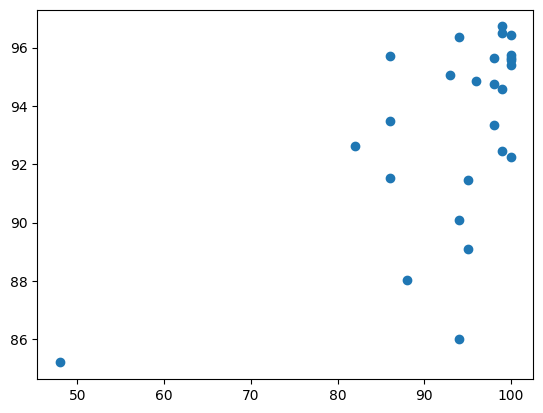

In [1154]:
plt.scatter(y_test, ensemble)

# Concat Features with Text Features

In [1155]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(126, 25) (126,)


In [1156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 100
Test set size: 26


In [1162]:
combined_train = np.concatenate((X_train, train_word2vec_p), axis=1)
X_train = pd.DataFrame(combined_train)

combined_test= np.concatenate((X_test, test_word2vec_p), axis=1)
X_test= pd.DataFrame(combined_test)

In [1166]:
from sklearn.linear_model import Lasso
DTregr = DecisionTreeRegressor()
DTregr.fit(X_train, y_train)

RFregr = RandomForestRegressor()
RFregr.fit(X_train, y_train)

SGDregr = Lasso()
SGDregr.fit(X_train, y_train)


DTpreds = DTregr.predict(X_test)
RFpreds = RFregr.predict(X_test)
SGDpreds = SGDregr.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Calculate MSE

DTmse = mean_squared_error(y_test, DTpreds)
DTr2 = r2_score(y_test, DTpreds)

RFmse = mean_squared_error(y_test, RFpreds)
RFr2 = r2_score(y_test, RFpreds)

SGDmse = mean_squared_error(y_test, SGDpreds)
SGDr2 = r2_score(y_test, SGDpreds)

print(DTmse, DTr2)
print(RFmse, RFr2)
print(SGDmse, SGDr2)

385.0769230769231 -0.18458787070703386
305.0168423076924 0.06169591033406263
374.7118391211528 -0.1527024161470556


## PCA

In [1167]:
from sklearn.decomposition import PCA
import pandas as pd

# Assuming df is your DataFrame
# Choose the number of components, e.g., 10 for illustration
pca = PCA(n_components=10)
pca.fit(X_train)

# Transform both training and test sets
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)


In [1168]:
DTregr = DecisionTreeRegressor()
DTregr.fit(train_pca, y_train)

RFregr = RandomForestRegressor()
RFregr.fit(train_pca, y_train)

SGDregr = SGDRegressor()
SGDregr.fit(train_pca, y_train)


DTpreds = DTregr.predict(test_pca)
RFpreds = RFregr.predict(test_pca)
SGDpreds = SGDregr.predict(test_pca)

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Calculate MSE

DTmse = mean_squared_error(y_test, DTpreds)
DTr2 = r2_score(y_test, DTpreds)

RFmse = mean_squared_error(y_test, RFpreds)
RFr2 = r2_score(y_test, RFpreds)

SGDmse = mean_squared_error(y_test, SGDpreds)
SGDr2 = r2_score(y_test, SGDpreds)

print(DTmse, DTr2)
print(RFmse, RFr2)
print(SGDmse, SGDr2)

392.46153846153845 -0.20730469763229875
311.80403461538464 0.04081689837041347
2.476989648222445e+28 -7.619807153608767e+25


## Simulated Annealing for Feature Subset Selection

In [1171]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline

#Datayı oku Feature'ları getir, vectorizer'dan da gelebilir, Objective function yazan fonksşyonun return parametresi r2 score olacak buna göre fonksiyonun düzenlenmesi gerekebilir.
#Ayrıca objective fonksyionda naive bayes classifier train ediliyor bunu bir regressor'a çevir.


def objective_function(combined_train, combined_test, y_train, y_test, subset):
    # Scale and normalize the features
    pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler()),
        ('normalizer', Normalizer())
    ])
    pipeline.fit(combined_train[:, subset])
    X_train = pipeline.transform(combined_train[:, subset])
    X_test = pipeline.transform(combined_test[:, subset])

    # Train a Gaussian Naive Bayes classifier
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = regressor.predict(X_test)
    return r2_score(y_test, y_pred), y_pred

# Implement simulated annealing for feature selection
def simulated_annealing(combined_train, combined_test, y_train, y_test, max_iter=1000, initial_temp=90, final_temp=1):
    # Start with all features
    current_solution = np.array(range(combined_train.shape[1]))
    current_score, y_pred = objective_function(combined_train, combined_test, y_train, y_test, current_solution)
    best_solution = current_solution.copy()
    best_score = current_score
    best_pred = y_pred

    # Cooling schedule
    temp = initial_temp
    cooling_rate = (final_temp / initial_temp) ** (1 / max_iter)

    for iteration in range(max_iter):
        # Create a new candidate solution
        candidate_solution = current_solution.copy()
        if np.random.rand() > 0.5:
            # Add a feature if not all features are included
            if len(candidate_solution) != combined_train.shape[1]:
                possible_additions = np.setdiff1d(range(combined_train.shape[1]), candidate_solution)
                feature_to_add = np.random.choice(possible_additions)
                candidate_solution = np.append(candidate_solution, feature_to_add)
        else:
            # Remove a feature if more than one feature is included
            if len(candidate_solution) > 1:
                feature_to_remove = np.random.choice(candidate_solution)
                candidate_solution = candidate_solution[candidate_solution != feature_to_remove]

        # Evaluate the candidate solution
        candidate_score, y_pred = objective_function(combined_train, combined_test, y_train, y_test, candidate_solution)

        # Decide whether to accept the candidate
        if (candidate_score > current_score or
            np.random.rand() < np.exp((candidate_score - current_score) / temp)):
            current_solution = candidate_solution.copy()
            current_score = candidate_score

            # Update the best solution found
            if candidate_score > best_score:
                best_solution = candidate_solution.copy()
                best_score = candidate_score
                best_pred = y_pred

        # Cool down the temperature
        temp *= cooling_rate

    return best_solution, best_score, best_pred

# Run the simulated annealing algorithm

best_features, best_feature_score, best_pred = simulated_annealing(combined_train, combined_test, y_train, y_test)

print(f"Best feature set: {best_features}")
print(f"Best feature score: {best_feature_score}")
print(f"Best predictions: {best_pred}")


# Bin Classification -> Grade Regression

In [955]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = ""
    for conv in convos:
        if conv["role"] == "user":
            user_prompts = user_prompts + " " + conv["text"]
    if(user_prompts == ""):
      continue
    prompts.append(user_prompts)
    code2prompts[code] = user_prompts

In [956]:
answers = []
code2answers= defaultdict(list)
for code , convos in code2convos.items():
    gpt_ans = ""
    for conv in convos:
        if conv["role"] == "assistant":
            gpt_ans = gpt_ans + " " + conv["text"]
    if(gpt_ans == ""):
      continue
    answers.append([gpt_ans])
    code2answers[code] = gpt_ans

In [957]:
#bins = [0, 40, 60, 80, 90, 97, 100]
bins = [0, 60, 84, 93, 100]
scores['grade_bin'] = pd.cut(scores['grade'], bins=bins, labels=False)

In [958]:
code_prompts = pd.DataFrame(code2prompts, index=[0]).T
code_prompts.reset_index(inplace=True)
code_prompts.rename(columns={0: "prompts"}, inplace=True)
code_prompts.rename(columns={"index" : "code"}, inplace=True)

In [959]:
code_ans = pd.DataFrame(code2answers, index=[0]).T
code_ans.reset_index(inplace=True)
code_ans.rename(columns={0: "answers"}, inplace=True)
code_ans.rename(columns={"index" : "code"}, inplace=True)

In [960]:
df_prompt = pd.merge(code_prompts, scores, on="code", how="left")
df_prompt.head()

,code,prompts,grade,grade_bin
0,0031c86e-81f4-4eef-9e0e-28037abf9883,Load a CSV file into a Pandas in Python. The ...,48.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,I have a dataset that contains the following ...,99.0,3.0
2,041f950b-c013-409a-a642-cffff60b9d4b,I have a csv file data with Columns:\n\nspeci...,90.0,2.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,How can I display variable names in a pandas ...,97.0,3.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,I am doing a machine leraning homework using ...,100.0,3.0


In [961]:
# Convert to lower case
df_prompt['prompts'] = df_prompt['prompts'].str.lower()

In [962]:
df_prompt.dropna(inplace=True)
df_prompt.drop_duplicates("code",inplace=True, keep="first")

In [963]:
## FOR BIN CLASSIFICATION WITH PROMPTS
one_hot = pd.get_dummies(df_prompt['grade_bin'])
# Drop column B as it is now encoded
df_prompt_bin = df_prompt.drop('grade_bin',axis = 1)
df_prompt_bin = df_prompt_bin.drop('grade',axis = 1)
# Join the encoded df
df_prompt_bin = df_prompt_bin.join(one_hot)

In [964]:
df_ans = pd.merge(code_ans, scores, on="code", how="left")
df_ans.head()

,code,answers,grade,grade_bin
0,0031c86e-81f4-4eef-9e0e-28037abf9883,You can load a CSV file into a Pandas DataFra...,48.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,Great! It looks like you have a comprehensive...,99.0,3.0
2,041f950b-c013-409a-a642-cffff60b9d4b,Certainly! Let's go through each step.Step 1:...,90.0,2.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,"In Pandas, you can display variable (column) ...",97.0,3.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,Absolutely! Here's the code to import the nec...,100.0,3.0


In [965]:
# Convert to lower case
df_ans['answers'] = df_ans['answers'].str.lower()

In [966]:
df_ans.dropna(inplace=True)
df_ans.drop_duplicates("code",inplace=True, keep="first")

In [967]:
## FOR BIN CLASSIFICATION WITH ANSWERS
one_hot = pd.get_dummies(df_ans['grade_bin'])
# Drop column B as it is now encoded
df_ans_bin = df_ans.drop('grade_bin',axis = 1)
df_ans_bin = df_ans_bin.drop('grade',axis = 1)
# Join the encoded df
df_ans_bin = df_ans_bin.join(one_hot)

In [968]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_prompt['prompts'], df_prompt['grade'], test_size=0.2, random_state=42)
print("Train set size:", len(X_train_p))
print("Test set size:", len(X_test_p))

X_train_p_bin, X_test_p_bin, y_train_p_bin, y_test_p_bin = train_test_split(df_prompt_bin['prompts'], df_prompt_bin.iloc[:, 2:], test_size=0.2, random_state=42)
print("Train set size:", len(X_train_p_bin))
print("Test set size:", len(X_test_p_bin))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


In [969]:
X_train, X_test, y_train, y_test = train_test_split(df_ans['answers'], df_ans['grade'], test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(df_ans_bin['answers'], df_ans_bin.iloc[:, 2:], test_size=0.2, random_state=42)
print("Train set size:", len(X_train_p_bin))
print("Test set size:", len(X_test_p_bin))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


## Map Features to Predict Bin

In [996]:
question_mapping_scores = pd.merge(temp_df, scores, on=["code", "grade"], how="left")
question_mapping_scores.head()

#question_mapping_s = question_mapping_scores.drop('grade_bin', axis = 1)
question_mapping_s = question_mapping_scores.copy()
question_mapping_s.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,#error,#why,#correlation,...,Q_5,Q_6,Q_7,Q_8,Total_Score,Average,std,Cluster,grade,grade_bin
0,6a2003ad-a05a-41c9-9d48-e98491a90499,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.059760,0.044272,0.030223,0.060247,4.122640,0.038039,0.026245,3.0,90.0,2.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,3.0,...,0.309084,0.192434,0.261892,0.407106,27.899428,0.261374,0.093911,0.0,97.0,3.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,20.0,0.0,0.0,3.0,0.0,9.0,0.0,1.0,0.0,...,0.834963,0.749319,0.457643,0.530808,64.142892,0.600445,0.203886,4.0,94.0,3.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,17.0,0.0,0.0,2.0,1.0,8.0,2.0,2.0,0.0,...,0.889976,0.947377,0.827463,0.562910,80.912376,0.714626,0.240134,2.0,97.0,3.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,66.0,0.0,0.0,9.0,11.0,30.0,1.0,5.0,8.0,...,0.606780,1.000000,1.000000,0.717228,86.707656,0.811366,0.279182,2.0,93.0,2.0


In [997]:
one_hot = pd.get_dummies(question_mapping_s['grade_bin'])

# Rename columns with descriptive names
new_column_names = {
    0.0: 'B_0',
    1.0: 'B_1',
    2.0: 'B_2',
    3.0: 'B_3'
}

one_hot.rename(columns=new_column_names, inplace=True)

# Drop the original 'grade_bin' and 'grade' columns
question_mapping_s = question_mapping_s.drop(['grade_bin'], axis=1)

# Join the encoded dataframe
question_mapping_s = question_mapping_s.join(one_hot)

In [998]:
df_counts_features =  question_mapping_s

## Vectorizers

In [999]:
# ANSWERS
from sklearn.feature_extraction.text import CountVectorizer

max_features = 200
vectorizer = CountVectorizer(max_features=max_features, preprocessor=lambda x: x)

# Fit the vectorizer to your train data
vectorizer.fit(X_train_bin)

# Transform the train and test data
train_bow = vectorizer.transform(X_train_bin).toarray()
test_bow = vectorizer.transform(X_test_bin).toarray()

# PROMPTS
vectorizer_p = CountVectorizer(max_features=max_features, preprocessor=lambda x: x)
# Fit the vectorizer to your train data
vectorizer_p.fit(X_train_p_bin)
# Transform the train and test data
train_bow_p = vectorizer_p.transform(X_train_p_bin).toarray()
test_bow_p = vectorizer_p.transform(X_test_p_bin).toarray()

In [1000]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 200
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)
tfidf_vectorizer.fit(X_train_bin)

# Transform the train and test data
train_tfidf = tfidf_vectorizer.transform(X_train_bin).toarray()
test_tfidf = tfidf_vectorizer.transform(X_test_bin).toarray()


tfidf_vectorizer_p = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)
tfidf_vectorizer_p.fit(X_train_p_bin)

# Transform the train and test data
train_tfidf_p = tfidf_vectorizer_p.transform(X_train_p_bin).toarray()
test_tfidf_p = tfidf_vectorizer_p.transform(X_test_p_bin).toarray()

In [1001]:
import gensim.downloader
from gensim.models import Word2Vec

In [1002]:
# Converting sentences to list of words
sentences = [sentence.split() for sentence in X_train_bin]
sentences_p = [sentence.split() for sentence in X_train_p_bin]
# Training model
vector_size = 20
window = 5
min_count = 5

word_to_vec = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

word_to_vec_p = Word2Vec(
    sentences_p,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [1003]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# This function should convert each review to a fixed-sized vector representation
def vectorize(review, word_to_vec):
    words = review.split()
    # Remove words that are not in the Word2Vec model's vocabulary
    words = [word for word in words if word in word_to_vec.wv]

    if len(words) == 0:
        # If no words are present in the Word2Vec model's vocabulary, return a zero vector
        return np.zeros(vector_size)

    # Calculate the average of word vectors
    review_vector = np.mean([word_to_vec.wv[word] for word in words], axis=0)
    return review_vector

# Applying your function to convert the train and test reviews to vector representations
train_word2vec = np.array([vectorize(review, word_to_vec) for review in X_train_bin])
test_word2vec = np.array([vectorize(review, word_to_vec) for review in X_test_bin])

In [1004]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# This function should convert each review to a fixed-sized vector representation
def vectorize(review, word_to_vec):
    words = review.split()
    # Remove words that are not in the Word2Vec model's vocabulary
    words = [word for word in words if word in word_to_vec.wv]

    if len(words) == 0:
        # If no words are present in the Word2Vec model's vocabulary, return a zero vector
        return np.zeros_like(word_to_vec.wv["word"])

    # Calculate the average of word vectors
    review_vector = np.mean([word_to_vec.wv[word] for word in words], axis=0)
    return review_vector

# Applying your function to convert the train and test reviews to vector representations
train_word2vec_p = np.array([vectorize(review, word_to_vec_p) for review in X_train_p_bin])
test_word2vec_p = np.array([vectorize(review, word_to_vec_p) for review in X_test_p_bin])

## Neural Networks

In [1005]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

NN_model_bow = Sequential()
NN_model_bow.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model_bow.add(Dropout(0.5))
NN_model_bow.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model_bow.add(Dropout(0.5))
NN_model_bow.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model_bow.add(Dense(4, activation='softmax'))

# Compile the network :
NN_model_bow.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model_bow.fit(train_bow, y_train_bin, epochs=30, batch_size=4)

NN_model_bow_p = Sequential()
NN_model_bow_p.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model_bow_p.add(Dropout(0.5))
NN_model_bow_p.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model_bow_p.add(Dropout(0.5))
NN_model_bow_p.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model_bow_p.add(Dense(4, activation='softmax'))

# Compile the network :
NN_model_bow_p.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model_bow_p.fit(train_bow_p, y_train_p_bin, epochs=30, batch_size=4)


Epoch 1/30
25/25 [==============================] - 2s 7ms/step - loss: 3.7151 - accuracy: 0.4536
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 1.8416 - accuracy: 0.4330
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 1.5194 - accuracy: 0.4227
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 1.5475 - accuracy: 0.5052
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 1.0916 - accuracy: 0.5258
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 1.2076 - accuracy: 0.5361
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 1.1598 - accuracy: 0.5876
Epoch 8/30
25/25 [==============================] - 0s 6ms/step - loss: 1.1113 - accuracy: 0.5773
Epoch 9/30
25/25 [==============================] - 0s 7ms/step - loss: 1.1434 - accuracy: 0.5258
Epoch 10/30
25/25 [==============================] - 0s 7ms/step - loss: 1.1871 - accuracy: 0.5979
Epoch 11/30
25/25 [

In [1006]:
pred_bow = NN_model_bow.predict(test_bow)
loss_bow, accuracy_bow = NN_model_bow.evaluate(test_bow, y_test_bin)

pred_bow_p = NN_model_bow_p.predict(test_bow_p)
loss_bow_p, accuracy_bow_p = NN_model_bow_p.evaluate(test_bow_p, y_test_p_bin)

1/1 [==============================] - 0s 174ms/step - loss: 1.5303 - accuracy: 0.6800


In [1007]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

NN_model_tfidf = Sequential()
NN_model_tfidf.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model_tfidf.add(Dropout(0.5))
NN_model_tfidf.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model_tfidf.add(Dropout(0.5))
NN_model_tfidf.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model_tfidf.add(Dropout(0.5))
NN_model_tfidf.add(Dense(4, activation='softmax'))

# Compile the network :
NN_model_tfidf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model_tfidf.fit(train_tfidf, y_train_bin, epochs=40, batch_size=4)

NN_model_tfidf_p = Sequential()
NN_model_tfidf_p.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model_tfidf_p.add(Dropout(0.5))
NN_model_tfidf_p.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model_tfidf_p.add(Dropout(0.5))
NN_model_tfidf_p.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model_tfidf_p.add(Dropout(0.5))
NN_model_tfidf_p.add(Dense(4, activation='softmax'))

# Compile the network :
NN_model_tfidf_p.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model_tfidf_p.fit(train_tfidf_p, y_train_p_bin, epochs=40, batch_size=4)

Epoch 1/40
25/25 [==============================] - 2s 4ms/step - loss: 1.3378 - accuracy: 0.5052
Epoch 2/40
25/25 [==============================] - 0s 5ms/step - loss: 1.2064 - accuracy: 0.5876
Epoch 3/40
25/25 [==============================] - 0s 5ms/step - loss: 1.1437 - accuracy: 0.5979
Epoch 4/40
25/25 [==============================] - 0s 5ms/step - loss: 1.1085 - accuracy: 0.6082
Epoch 5/40
25/25 [==============================] - 0s 4ms/step - loss: 1.0941 - accuracy: 0.6082
Epoch 6/40
25/25 [==============================] - 0s 6ms/step - loss: 1.0768 - accuracy: 0.6082
Epoch 7/40
25/25 [==============================] - 0s 6ms/step - loss: 1.1032 - accuracy: 0.5979
Epoch 8/40
25/25 [==============================] - 0s 6ms/step - loss: 1.0641 - accuracy: 0.5979
Epoch 9/40
25/25 [==============================] - 0s 6ms/step - loss: 1.0186 - accuracy: 0.5979
Epoch 10/40
25/25 [==============================] - 0s 6ms/step - loss: 1.0284 - accuracy: 0.6186
Epoch 11/40
25/25 [

In [1008]:
pred_tfidf = NN_model_tfidf.predict(test_tfidf)
loss_tfidf, accuracy_tfidf = NN_model_tfidf.evaluate(test_tfidf, y_test_bin)

pred_tfidf_p = NN_model_tfidf_p.predict(test_tfidf_p)
loss_tfidf_p, accuracy_tfidf_p = NN_model_tfidf_p.evaluate(test_tfidf_p, y_test_p_bin)

1/1 [==============================] - 1s 880ms/step - loss: 1.2444 - accuracy: 0.6400


In [1009]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

NN_model = Sequential()
NN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(4, activation='softmax'))

# Compile the network :
NN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model.fit(train_word2vec, y_train_bin, epochs=200, batch_size=4)

NN_model_p = Sequential()
NN_model_p.add(Dense(128, kernel_initializer='normal', activation='relu'))
NN_model_p.add(Dropout(0.5))
NN_model_p.add(Dense(64, kernel_initializer='normal', activation='relu'))
NN_model_p.add(Dropout(0.5))
NN_model_p.add(Dense(32, kernel_initializer='normal',activation='relu'))
NN_model_p.add(Dropout(0.5))
NN_model_p.add(Dense(4, activation='softmax'))

# Compile the network :
NN_model_p.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model_p.fit(train_word2vec_p, y_train_p_bin, epochs=200, batch_size=4)

Epoch 1/200
25/25 [==============================] - 5s 11ms/step - loss: 1.3626 - accuracy: 0.3505
Epoch 2/200
25/25 [==============================] - 0s 11ms/step - loss: 1.2322 - accuracy: 0.5979
Epoch 3/200
25/25 [==============================] - 0s 7ms/step - loss: 1.1109 - accuracy: 0.6186
Epoch 4/200
25/25 [==============================] - 0s 10ms/step - loss: 1.0983 - accuracy: 0.6186
Epoch 5/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1018 - accuracy: 0.5876
Epoch 6/200
25/25 [==============================] - 0s 8ms/step - loss: 1.1429 - accuracy: 0.5979
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 1.0353 - accuracy: 0.6289
Epoch 8/200
25/25 [==============================] - 0s 9ms/step - loss: 1.0404 - accuracy: 0.6082
Epoch 9/200
25/25 [==============================] - 0s 9ms/step - loss: 1.1098 - accuracy: 0.6082
Epoch 10/200
25/25 [==============================] - 0s 7ms/step - loss: 1.0454 - accuracy: 0.6082
Epoch 

In [1010]:
pred_w2v = NN_model.predict(test_word2vec)
loss_w2v, accuracy_w2v = NN_model.evaluate(test_word2vec, y_test_bin)

pred_w2v_p = NN_model_p.predict(test_word2vec_p)
loss_w2v_p, accuracy_w2v_p = NN_model_p.evaluate(test_word2vec_p, y_test_p_bin)

1/1 [==============================] - 0s 288ms/step - loss: 0.9533 - accuracy: 0.6000


## Ensemble Bin Classification Results

In [1011]:
from sklearn.metrics import accuracy_score, classification_report
def soft_voting(pred_bow, pred_tfidf, pred_w2v):
    predictions = [pred_bow, pred_tfidf, pred_w2v]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

def hard_voting(pred_bow, pred_tfidf, pred_w2v, num_classes):
    predictions = [np.argmax([pred_bow, pred_tfidf, pred_w2v], axis=1)]
    votes = np.apply_along_axis(lambda x: np.bincount(x, minlength=num_classes), axis=0, arr=np.array(predictions))
    return np.argmax(votes, axis=0)


def weighted_soft_voting(pred_bow, pred_tfidf, pred_w2v, weights):
    predictions = [pred_bow, pred_tfidf, pred_w2v]
    weighted_predictions = np.average(predictions, axis=0, weights=weights)
    return np.argmax(weighted_predictions, axis=1)

def weighted_hard_voting(pred_bow, pred_tfidf, pred_w2v, weights, num_classes):
    # Determine the total number of samples
    total_samples = pred_bow.samples

    # Initialize the weighted_votes array
    weighted_votes = np.zeros((total_samples, num_classes))

    # Accumulate predictions from each model
    predictions = [pred_bow, pred_tfidf, pred_w2v]

    for j, pred in enumerate(predictions):
          weighted_votes[j][pred] += weights[i]

    return np.argmax(weighted_votes, axis=1)


# Example usage
weights = [0.35, 0.4, 0.25]  # Example weights, adjust as needed

# Now you can call any of the voting functions with these models and weights
num_classes = 3  # Replace with the actual number of classes in your dataset

# Soft Voting
soft_voting_predictions = soft_voting(pred_bow, pred_tfidf, pred_w2v)
# Hard Voting
#hard_voting_predictions = hard_voting(pred_bow, pred_tfidf, pred_w2v, num_classes)
# Weighted Soft Voting
weighted_soft_voting_predictions = weighted_soft_voting(pred_bow, pred_tfidf, pred_w2v, weights)
# Weighted Hard Voting
#weighted_hard_voting_predictions = weighted_hard_voting(pred_bow, pred_tfidf, pred_w2v, weights, num_classes)


# Assuming you have true labels in a one-hot encoded format
df = pd.DataFrame(y_test_bin)
true_labels_flat = np.argmax(df.iloc[:, 0:].values, axis=1)


# Evaluate Soft Voting
accuracy_soft = accuracy_score(true_labels_flat, soft_voting_predictions)
print(f'Soft Voting Accuracy: {accuracy_soft}')
print(classification_report(true_labels_flat, soft_voting_predictions))

"""
# Evaluate Hard Voting
accuracy_hard = accuracy_score(true_labels_flat, hard_voting_predictions)
print(f'Hard Voting Accuracy: {accuracy_hard}')
print(classification_report(true_labels_flat, hard_voting_predictions))
"""
# Evaluate Weighted Soft Voting
accuracy_weighted_soft = accuracy_score(true_labels_flat, weighted_soft_voting_predictions)
print(f'Weighted Soft Voting Accuracy: {accuracy_weighted_soft}')
print(classification_report(true_labels_flat, weighted_soft_voting_predictions))
"""
# Evaluate Weighted Hard Voting
accuracy_weighted_hard = accuracy_score(true_labels_flat, weighted_hard_voting_predictions)
print(f'Weighted Hard Voting Accuracy: {accuracy_weighted_hard}')
print(classification_report(true_labels_flat, weighted_hard_voting_predictions))
"""

def weighted_soft_voting_prob(models, generator, weights):
    predictions = [pred_bow, pred_tfidf, pred_w2v]
    weighted_predictions = np.average(predictions, axis=0, weights=weights)
    return weighted_predictions  # Returns averaged probabilities





Soft Voting Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         7
           3       0.64      1.00      0.78        16

    accuracy                           0.64        25
   macro avg       0.16      0.25      0.20        25
weighted avg       0.41      0.64      0.50        25

Weighted Soft Voting Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         7
           3       0.64      1.00      0.78        16

    accuracy                           0.64        25
   macro avg       0.16      0.25      0.20        25
weighted avg       0.41      0.64      0.50        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [1012]:
from sklearn.metrics import accuracy_score, classification_report
def soft_voting(pred_bow, pred_tfidf, pred_w2v):
    predictions = [pred_bow, pred_tfidf, pred_w2v]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

def hard_voting(pred_bow, pred_tfidf, pred_w2v, num_classes):
    predictions = [np.argmax([pred_bow, pred_tfidf, pred_w2v], axis=1)]
    votes = np.apply_along_axis(lambda x: np.bincount(x, minlength=num_classes), axis=0, arr=np.array(predictions))
    return np.argmax(votes, axis=0)


def weighted_soft_voting(pred_bow, pred_tfidf, pred_w2v, weights):
    predictions = [pred_bow, pred_tfidf, pred_w2v]
    weighted_predictions = np.average(predictions, axis=0, weights=weights)
    return np.argmax(weighted_predictions, axis=1)

def weighted_hard_voting(pred_bow, pred_tfidf, pred_w2v, weights, num_classes):
    # Determine the total number of samples
    total_samples = pred_bow.samples

    # Initialize the weighted_votes array
    weighted_votes = np.zeros((total_samples, num_classes))

    # Accumulate predictions from each model
    predictions = [pred_bow, pred_tfidf, pred_w2v]

    for j, pred in enumerate(predictions):
          weighted_votes[j][pred] += weights[i]

    return np.argmax(weighted_votes, axis=1)


# Example usage
weights = [0.30, 0.10, 0.60]  # Example weights, adjust as needed

# Now you can call any of the voting functions with these models and weights
num_classes = 3  # Replace with the actual number of classes in your dataset

# Soft Voting
soft_voting_predictions_p = soft_voting(pred_bow_p, pred_tfidf_p, pred_w2v_p)
# Hard Voting
#hard_voting_predictions = hard_voting(pred_bow, pred_tfidf, pred_w2v, num_classes)
# Weighted Soft Voting
weighted_soft_voting_predictions_p = weighted_soft_voting(pred_bow_p, pred_tfidf_p, pred_w2v_p, weights)
# Weighted Hard Voting
#weighted_hard_voting_predictions = weighted_hard_voting(pred_bow, pred_tfidf, pred_w2v, weights, num_classes)


# Assuming you have true labels in a one-hot encoded format
df = pd.DataFrame(y_test_p_bin)
true_labels_flat = np.argmax(df.iloc[:, 0:].values, axis=1)


# Evaluate Soft Voting
accuracy_soft = accuracy_score(true_labels_flat, soft_voting_predictions_p)
print(f'Soft Voting Accuracy: {accuracy_soft}')
print(classification_report(true_labels_flat, soft_voting_predictions_p))

"""
# Evaluate Hard Voting
accuracy_hard = accuracy_score(true_labels_flat, hard_voting_predictions)
print(f'Hard Voting Accuracy: {accuracy_hard}')
print(classification_report(true_labels_flat, hard_voting_predictions))
"""
# Evaluate Weighted Soft Voting
accuracy_weighted_soft_p = accuracy_score(true_labels_flat, weighted_soft_voting_predictions_p)
print(f'Weighted Soft Voting Accuracy: {accuracy_weighted_soft_p}')
print(classification_report(true_labels_flat, weighted_soft_voting_predictions_p))
"""
# Evaluate Weighted Hard Voting
accuracy_weighted_hard = accuracy_score(true_labels_flat, weighted_hard_voting_predictions)
print(f'Weighted Hard Voting Accuracy: {accuracy_weighted_hard}')
print(classification_report(true_labels_flat, weighted_hard_voting_predictions))
"""

def weighted_soft_voting_prob(models, generator, weights):
    predictions = [pred_bow, pred_tfidf, pred_w2v]
    weighted_predictions = np.average(predictions, axis=0, weights=weights)
    return weighted_predictions  # Returns averaged probabilities





Soft Voting Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      0.14      0.22         7
           3       0.68      0.94      0.79        16

    accuracy                           0.64        25
   macro avg       0.30      0.27      0.25        25
weighted avg       0.58      0.64      0.57        25

Weighted Soft Voting Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         7
           3       0.65      0.94      0.77        16

    accuracy                           0.60        25
   macro avg       0.16      0.23      0.19        25
weighted avg       0.42      0.60      0.49        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [1013]:
from sklearn.metrics import accuracy_score, classification_report
def soft_voting(pred_bow, pred_tfidf, pred_w2v,pred_bow_p, pred_tfidf_p, pred_w2v_p):
    predictions = [pred_bow, pred_tfidf, pred_w2v,pred_bow_p, pred_tfidf_p, pred_w2v_p]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

def weighted_soft_voting(pred_bow, pred_tfidf, pred_w2v,pred_bow_p, pred_tfidf_p, pred_w2v_p, weights):
    predictions = [pred_bow, pred_tfidf, pred_w2v,pred_bow_p, pred_tfidf_p, pred_w2v_p]
    weighted_predictions = np.average(predictions, axis=0, weights=weights)
    return np.argmax(weighted_predictions, axis=1)

# Example usage
weights = [0.10, 0.2, 0.3, 0.10, 0.10, 0.20]  # Example weights, adjust as needed

# Soft Voting
soft_voting_predictions = soft_voting(pred_bow, pred_tfidf, pred_w2v,pred_bow_p, pred_tfidf_p, pred_w2v_p)
weighted_soft_voting_predictions = weighted_soft_voting(pred_bow, pred_tfidf, pred_w2v,pred_bow_p, pred_tfidf_p, pred_w2v_p, weights)


# Assuming you have true labels in a one-hot encoded format
df = pd.DataFrame(y_test_p_bin)
true_labels_flat = np.argmax(df.iloc[:, 0:].values, axis=1)


# Evaluate Soft Voting
accuracy_soft = accuracy_score(true_labels_flat, soft_voting_predictions)
print(f'Soft Voting Accuracy: {accuracy_soft}')
print(classification_report(true_labels_flat, soft_voting_predictions))

# Evaluate Weighted Soft Voting
accuracy_weighted_soft_p = accuracy_score(true_labels_flat, weighted_soft_voting_predictions)
print(f'Weighted Soft Voting Accuracy: {accuracy_weighted_soft_p}')
print(classification_report(true_labels_flat, weighted_soft_voting_predictions))



Soft Voting Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         7
           3       0.64      1.00      0.78        16

    accuracy                           0.64        25
   macro avg       0.16      0.25      0.20        25
weighted avg       0.41      0.64      0.50        25

Weighted Soft Voting Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         7
           3       0.64      1.00      0.78        16

    accuracy                           0.64        25
   macro avg       0.16      0.25      0.20        25
weighted avg       0.41      0.64      0.50        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

## Predict & Analyze Each Bin Seperately

In [1014]:
import pandas as pd

# Convert array to DataFrame
grades_df = pd.DataFrame(soft_voting_predictions, columns=['grade'])

# Perform one-hot encoding
one_hot = pd.get_dummies(grades_df['grade'], prefix='B')

# All possible categories (0 to 6)
all_categories = range(4)

# Add missing categories as columns with 0 values
for category in all_categories:
    column_name = f'B_{category}'
    if column_name not in one_hot.columns:
        one_hot[column_name] = 0

# Order the columns if desired
one_hot = one_hot[[f'B_{i}' for i in all_categories]]

# The one_hot DataFrame now has the one-hot encoded values including missing categories
print(one_hot.head())


   B_0  B_1  B_2  B_3
0    0    0    0    1
1    0    0    0    1
2    0    0    0    1
3    0    0    0    1
4    0    0    0    1


In [1015]:
train_df = pd.merge(X_train_bin, df_counts_features, left_index=True, right_index=True, how='inner')
train_df.drop(['answers'], inplace = True, axis =1)

test_df = pd.merge(X_test_bin, df_counts_features, left_index=True, right_index=True, how='inner')
y_test = test_df['grade']
test_df.drop(['grade', 'code', 'answers', 'B_0','B_1','B_2', 'B_3'], inplace = True, axis =1)

In [1016]:
test_df

,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,#error,#why,#correlation,#how,...,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Total_Score,Average,std,Cluster
21,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.493002,0.462470,0.158104,0.176167,0.136562,0.086620,19.579856,0.209079,0.155941,3.0
54,17.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,6.0,...,0.950344,0.933339,0.733244,0.947377,0.945305,0.232195,79.819913,0.723710,0.293401,2.0
57,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.081577,0.064473,0.066042,0.056649,0.070091,0.046043,8.269662,0.079193,0.040847,3.0
105,20.0,0.0,0.0,3.0,1.0,7.0,5.0,2.0,0.0,1.0,...,0.950344,0.957975,0.947105,1.000000,0.893185,0.739056,92.505863,0.830587,0.255647,2.0
4,66.0,0.0,0.0,9.0,11.0,30.0,1.0,5.0,8.0,3.0,...,1.000000,0.942662,0.606780,1.000000,1.000000,0.717228,86.707656,0.811366,0.279182,2.0
48,11.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,6.0,...,0.140084,0.138012,0.141899,0.166211,0.145883,0.177824,15.732878,0.150434,0.032652,3.0
75,19.0,0.0,0.0,1.0,10.0,1.0,0.0,0.0,0.0,15.0,...,0.411720,0.598931,0.500014,0.381336,0.362256,0.207686,37.990165,0.333183,0.163679,0.0
123,21.0,0.0,0.0,7.0,4.0,0.0,0.0,0.0,2.0,5.0,...,0.153620,0.968112,0.145543,0.151680,0.148341,0.352982,25.977312,0.262609,0.274806,0.0
35,46.0,0.0,0.0,3.0,49.0,19.0,6.0,4.0,9.0,8.0,...,0.294068,0.724872,0.987511,0.892586,0.893185,0.740520,81.996611,0.665793,0.291602,1.0
67,62.0,5.0,0.0,10.0,28.0,3.0,3.0,0.0,10.0,5.0,...,0.264559,0.558186,0.549874,0.274764,0.406042,0.302961,37.576110,0.322620,0.155517,0.0


In [1017]:
b1_train = train_df[train_df['B_0'] == 1]
b2_train = train_df[train_df['B_1'] == 1]
b3_train = train_df[train_df['B_2'] == 1]
b4_train = train_df[train_df['B_3'] == 1]

In [1018]:
y_train_1 = b1_train['grade']
X_train_1 = b1_train.drop(['grade', 'code', 'B_0','B_1','B_2','B_3'], axis = 1)

y_train_2 = b2_train['grade']
X_train_2 = b2_train.drop(['grade', 'code', 'B_0','B_1','B_2','B_3'], axis = 1)

y_train_3 = b3_train['grade']
X_train_3 = b3_train.drop(['grade', 'code', 'B_0','B_1','B_2','B_3'], axis = 1)

y_train_4 = b4_train['grade']
X_train_4 = b4_train.drop(['grade', 'code', 'B_0','B_1','B_2','B_3'], axis = 1)

In [1019]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge

regr_rf1 = RandomForestRegressor()
regr_rf2 = RandomForestRegressor()
regr_rf3 = RandomForestRegressor()
regr_rf4 = RandomForestRegressor()

regr_rf1.fit(X_train_1, y_train_1)
regr_rf2.fit(X_train_2, y_train_2)
regr_rf3.fit(X_train_3, y_train_3)
regr_rf4.fit(X_train_4, y_train_4)

RandomForestRegressor()

In [1020]:
grade_from_bin_preds = []
bins = soft_voting_predictions
for i in range(0, len(bins)):
  if bins[i] == 0:
    pred = regr_rf1.predict(test_df.iloc[[i]])
    grade_from_bin_preds.append(pred)
  elif bins[i] == 1:
    pred = regr_rf2.predict(test_df.iloc[[i]])
    grade_from_bin_preds.append(pred)
  elif bins[i] == 2:
    pred = regr_rf3.predict(test_df.iloc[[i]])
    grade_from_bin_preds.append(pred)
  else:
    pred = regr_rf4.predict(test_df.iloc[[i]])
    grade_from_bin_preds.append(pred)

r2_score(y_test,grade_from_bin_preds)

-0.9128780633135729

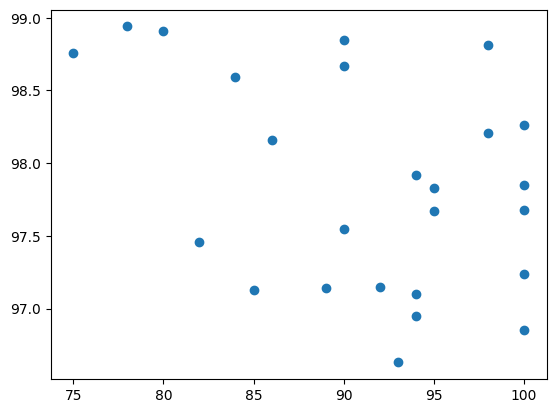

In [1022]:
plt.scatter(y_test, grade_from_bin_preds)

## Predict and Analyze Bin As A Feature

In [1023]:
train_df = pd.merge(X_train_bin, df_counts_features, left_index=True, right_index=True, how='inner')

In [1024]:
train_df.drop(['answers'], inplace = True, axis =1)

In [1025]:
test_df = pd.merge(X_test_bin, df_counts_features, left_index=True, right_index=True, how='inner')

In [1026]:
test_df.drop(['answers'], inplace = True, axis =1)

In [1027]:
y_train = train_df['grade']
X_train = train_df.drop(['grade', 'code'], axis = 1)

y_test = test_df['grade']
X_test = test_df.drop(['code', 'grade'], axis = 1)
X_test['B_0'] = one_hot['B_0'].to_numpy()
X_test['B_1'] = one_hot['B_1'].to_numpy()
X_test['B_2'] = one_hot['B_2'].to_numpy()
X_test['B_3'] = one_hot['B_3'].to_numpy()

In [1028]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression

regr = DecisionTreeRegressor()
regr_rf = RandomForestRegressor()
regr_sgd = LinearRegression()
regr.fit(X_train, y_train)
regr_rf.fit(X_train, y_train)
regr_sgd.fit(X_train, y_train)

LinearRegression()

In [1029]:
preds = regr.predict(X_test)
preds_rf = regr_rf.predict(X_test)
preds_sgd = regr_sgd.predict(X_test)

In [1030]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Calculate MSE
mse_rf = mean_squared_error(y_test, preds_rf)
r2_rf = r2_score(y_test, preds_rf)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
mse_sgd = mean_squared_error(y_test, preds_sgd)
r2_sgd = r2_score(y_test, preds_sgd)
print(mse, r2, mse_rf, r2_rf, mse_sgd, r2_sgd)

113.76 -1.1725844893968098 101.36433199999999 -0.9358524567622073 111.40598157372989 -1.12762752806885


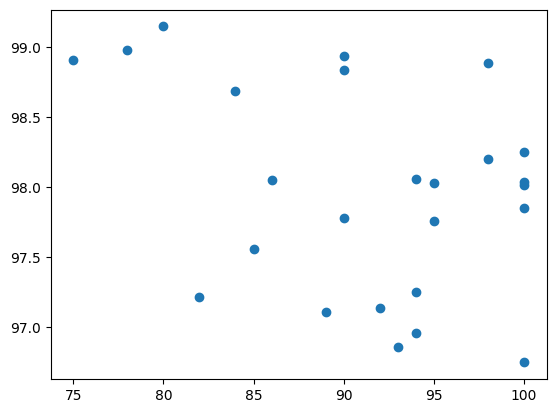

In [1031]:
plt.scatter(y_test, preds_rf)

# Ensemble Best of All

In [714]:
best_features = y_test_pred_rf
best_text_regression = ensemble
best_simulated_annealing = best_pred

best_preds = (0.15 * best_features + 0.15* best_text_regression + 0.7 * best_simulated_annealing)
print("R2:", r2_score(y_test, best_preds), "MSE:", mean_squared_error(y_test, best_preds))

R2: 0.5647513529590469 MSE: 48.86345050924082


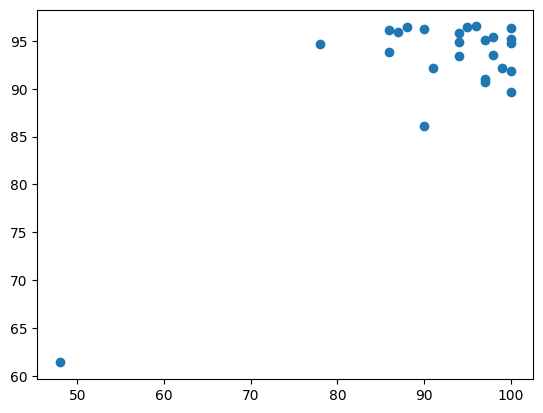

In [715]:
plt.scatter(y_test, best_preds)